#Mount and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Nov  3 07:40:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 14.5 MB/s 
     |████████████████████████████████| 2.9 MB 58.1 MB/s 
     |████████████████████████████████| 895 kB 65.0 MB/s 
     |████████████████████████████████| 126 kB 14.0 MB/s 
     |████████████████████████████████| 1.2 MB 13.2 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 556 (delta 182), reused 244 (delta 91), pack-reused 214
Receiving objects: 100% (556/556), 9.16 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Cloning into 'JUST-Arabic-Propaganda'...
remote: Enumerating objects: 1533, done.
remote: Counting objects: 100% (1533/1533), done.
remote: Compressing objects: 100% (1423/1423), done.
remote: Total 1533 (delta 49), reused 1518 (delta 37), pack-reused 0
Receiving objects: 100% (1533/1533), 3.02 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [4]:
!pip install -U scikit-learn

     |████████████████████████████████| 23.2 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [5]:
import pandas as pd
import numpy as np
import re

#General Methods

In [6]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

In [7]:
def get_dataloaders(train, valid, test, text_col_name='Arabic', vocabulary = None):
  train = MapLabels(train)
  valid = MapLabels(valid)
  test = MapLabels(test)

  train_X = train[text_col_name]
  train_y = train['label']

  valid_X = valid[text_col_name]
  valid_y = valid['label']

  test_X = test[text_col_name]
  test_y = test['label']

  ## Tokenize the sentences
  tokenizer = Tokenizer(num_words=config['max_features'])
  if vocabulary is not None:
    tokenizer.fit_on_texts(vocabulary)
  else:
    tokenizer.fit_on_texts(list(train_X))
  train_X = tokenizer.texts_to_sequences(train_X)
  valid_X = tokenizer.texts_to_sequences(valid_X)
  test_X = tokenizer.texts_to_sequences(test_X)

  ## Pad the sentences 
  train_X = pad_sequences(train_X, maxlen=config['maxlen'])
  train_y = train['onehot']

  valid_X = pad_sequences(valid_X, maxlen=config['maxlen'])
  valid_y = valid['onehot']

  test_X = pad_sequences(test_X, maxlen=config['maxlen'])
  test_y = test['onehot']

  # Load train and test in CUDA Memory
  x_train = torch.tensor(train_X, dtype=torch.long).cuda()
  y_train = torch.tensor(train_y, dtype=torch.long).cuda()

  x_valid = torch.tensor(valid_X, dtype=torch.long).cuda()
  y_valid = torch.tensor(valid_y, dtype=torch.long).cuda()

  x_test = torch.tensor(test_X, dtype=torch.long).cuda()
  y_test = torch.tensor(test_y, dtype=torch.long).cuda()

  # Create Torch datasets
  train_TensorDataset = torch.utils.data.TensorDataset(x_train, y_train)
  valid_TensorDataset = torch.utils.data.TensorDataset(x_valid, y_valid)
  test_TensorDataset = torch.utils.data.TensorDataset(x_test, y_test)

  # Create Data Loaders
  train_loader = DataLoader(train_TensorDataset, batch_size=config['train_batch_size'], shuffle=True)
  valid_loader = DataLoader(valid_TensorDataset, batch_size=config['valid_batch_size'], shuffle=False)
  test_loader = DataLoader(test_TensorDataset, batch_size=1, shuffle=False)

  return train_loader, valid_loader, test_loader

In [8]:
def train_fn(data_loader, model, optimizer, device):
  model.train()
  loss_function = nn.BCEWithLogitsLoss()
  for i, (inputs, targets) in tqdm(enumerate(data_loader), total=len(data_loader)):
    # Predict/Forward Pass
    # inputs: x_batch of shape (train_batch_size, num_labels)
    # targets: y_batch of shape (train_batch_size, num_labels)
    optimizer.zero_grad()

    outputs = model(inputs)

    targets = targets.float()
    loss = loss_function(outputs, targets)

    loss.backward()
    optimizer.step()

def eval_fn(data_loader, model, device):
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for i, (inputs, targets) in tqdm(enumerate(data_loader), total=len(data_loader)):
      outputs = model(inputs)

      targets = targets.float()

      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  
  return fin_outputs, fin_targets

In [9]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

In [53]:
def plot_performance(performance_dict, path):
  f1_micro = []
  accuracy = []

  for epoch_performance in performance_dict['MODEL_EPOCHS']:
    f1_micro.append(epoch_performance['F1-Micro'])
    accuracy.append(epoch_performance['Accuracy'])

  figure(figsize=(15, 6), dpi=100)
  epochs = range(1, len(performance_dict['MODEL_EPOCHS'])+1)

  # plot lines
  plt.scatter(epochs, f1_micro, label = "F1-Micro", color = 'blue')
  plt.scatter(epochs, accuracy, label = "Accuracy", color = 'red')
  plt.plot(epochs, f1_micro, color = 'blue')
  plt.plot(epochs, accuracy, color = 'red')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Score', fontsize=10)
  LAST_BEST_EPOCH = performance_dict['LAST_BEST_EPOCH']
  plt.title(label = "Performance of model over time on validation dataset")
  string = f'footnote: last best epoch is {LAST_BEST_EPOCH} with F1-Micro of {round(f1_micro[LAST_BEST_EPOCH-1], ndigits=4)} and Accuracy of {round(accuracy[LAST_BEST_EPOCH-1], ndigits=4)}'
  plt.figtext(x= 0.1, y = 0.01, s=string, fontsize=10, fontfamily='monospace')
  plt.xticks(np.arange(min(epochs)+1, max(epochs)+1, 2.0))
  plt.legend()
  plt.savefig(path,)
  plt.show()

In [11]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

In [12]:
def Test(train, valid, test, model):
  _, _, test_loader = get_dataloaders(train, valid, test)
  model.eval()
  device = torch.device(config['device'])
  model.to(device)

  outputs, targets = eval_fn(test_loader, model, device)
  outputs = np.array(outputs) >= 0.5
  accuracy = metrics.accuracy_score(targets, outputs)
  f1_micro = metrics.f1_score(targets, outputs,average='micro')
  print(f"<---------------Test Set Performance--------------->")
  print(f"f1-Micro Score = {f1_micro}")
  print(f"Accuracy Score = {accuracy}")

  gold_list = targets
  preds_list = outputs

  target_names = [
        'Appeal_to_Authority',
        'Appeal_to_fear-prejudice',
        'Bandwagon,Reductio_ad_hitlerum',
        'Black-and-White_Fallacy',
        'Causal_Oversimplification',
        'Doubt',
        'Exaggeration,Minimisation',
        'Flag-Waving',
        'Loaded_Language',
        'Name_Calling,Labeling',
        'Repetition',
        'Slogans',
        'Thought-terminating_Cliches',
        'Whataboutism,Straw_Men,Red_Herring']
  report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
  cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
  accuracy = metrics.accuracy_score(gold_list, preds_list)

  print()
  print(report)

  fig, ax = plt.subplots(2, 7, figsize=(30, 8))
  for axes, cmi, label in zip(ax.flatten(), cm, target_names):
      print_confusion_matrix(cmi, axes, label, ["N", "Y"])
  fig.tight_layout()
  plt.show()
  fig.savefig("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/output.png")

#Support Vector Machine

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import metrics
import time

In [30]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  target_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    label = row['label']
    target_col.append(map[label])
  
  df['target'] = target_col
  return df

In [34]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

In [44]:
def SVM_Tfidf(train, test):
  train = MapLabels(train)
  test = MapLabels(test)

  Tfidf_vect = TfidfVectorizer()
  Tfidf_vect.fit(train['Arabic'])

  Train_X_Tfidf = Tfidf_vect.transform(train['Arabic'])
  Test_X_Tfidf = Tfidf_vect.transform(test['Arabic'])

  Train_Y = np.array(train['target'].tolist())
  Test_Y = np.array(test['target'].tolist())
  # Classifier - Algorithm - SVM
  # fit the training dataset on the classifier
  start = time.time()
  SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', )
  SVM.fit(Train_X_Tfidf, Train_Y)
  end = time.time()
  # predict the labels on test dataset
  predictions_SVM = SVM.predict(Test_X_Tfidf)
  # Use accuracy_score function to get the accuracy
  f1_micro = metrics.f1_score(Test_Y, predictions_SVM,average='micro')
  print("SVM Accuracy Score: ",accuracy_score(predictions_SVM, Test_Y))
  print("SVM F1-Micro Score: ",f1_micro)
  print(f"Training efficiency: {round(end-start, ndigits=3)}")

In [45]:
SVM_Tfidf(train, test)

SVM Accuracy Score:  0.5680555555555555
SVM F1-Micro Score:  0.5680555555555555
Training efficiency: 4.241


#LSTM

In [6]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import gensim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

##Trainer Code

In [58]:
def Train(train, valid, test, pretrained_embeddings = None):
  target_names = [
    'Appeal_to_Authority',
    'Appeal_to_fear-prejudice',
    'Bandwagon,Reductio_ad_hitlerum',
    'Black-and-White_Fallacy',
    'Causal_Oversimplification',
    'Doubt',
    'Exaggeration,Minimisation',
    'Flag-Waving',
    'Loaded_Language',
    'Name_Calling,Labeling',
    'Repetition',
    'Slogans',
    'Thought-terminating_Cliches',
    'Whataboutism,Straw_Men,Red_Herring']
  train_loader, valid_loader, _ = get_dataloaders(train,
                                                  valid,
                                                  test,
                                                  vocabulary=pretrained_embeddings.index2word
                                                  )

  device = torch.device(config['device'])

  model = BiLSTM_model(max_features=config['max_features'],
                      embedding_dim=config['embedding_size'],
                      hidden_dim=config['lstm_hidden_dim'],
                      num_layers = config['num_lstm_layers'],
                      lstm_dropout = config['lstm_dropout'],
                      pretrained_embeddings=pretrained_embeddings,
                      )
  model.to(device)

  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])
  loss_function = nn.BCEWithLogitsLoss()

  best_score = 0
  last_best_epoch = 0
  performance = []
  for epoch in range(config['epochs']):
    train_fn(train_loader, model, optimizer, device)
    outputs, targets = eval_fn(valid_loader, model, device)
    outputs = np.array(outputs) >= 0.5

    accuracy = metrics.accuracy_score(targets, outputs)
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Micro':f1_micro,
                         'Accuracy':accuracy,
                         }
    performance.append(epoch_performance)
    if f1_micro > best_score:
      print("Saving model...")
      report = metrics.classification_report(targets,outputs,target_names=target_names, zero_division=0, digits=4)
      torch.save(model.state_dict(), config['model_save_path'])
      best_score = f1_micro
      last_best_epoch = epoch+1
  print(report)
  with open(config['model_args_path'], 'w') as fp:
    json.dump(config, fp)
  return performance, last_best_epoch

##Model Archi

In [59]:
# class BiLSTM_model(nn.Module) :
#     def __init__(self, max_features, embedding_dim, hidden_dim, num_layers, lstm_dropout):
#         # max_features is the vocabulary size (num of tokens/words).
#         super().__init__()
#         self.embeddings = nn.Embedding(max_features, embedding_dim, padding_idx=0)

#         self.lstm = nn.LSTM(embedding_dim,
#                             hidden_dim,
#                             batch_first=True,
#                             bidirectional=True,
#                             num_layers = num_layers,
#                             dropout=lstm_dropout)
#         self.relu=nn.ReLU()
#         self.fc1 = nn.Linear(hidden_dim * 2, 64)
#         self.dropout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(64, config['num_classes'])

#     def forward(self, input):
#         embeddings_out = self.embeddings(input)
#         lstm_out, (hidden, cell) = self.lstm(embeddings_out)
#         hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         rel = self.relu(hidden)
#         dense1 = self.fc1(rel)
#         drop = self.dropout(dense1)
#         final_out = self.fc2(drop)

#         return final_out

In [60]:
class BiLSTM_model(torch.nn.Module) :
    def __init__(self, max_features, embedding_dim, hidden_dim, num_layers, lstm_dropout, pretrained_embeddings = None) :
        # max_features is the vocabulary size (num of tokens/words).
        super().__init__()
        if pretrained_embeddings is not None:
          weights = torch.FloatTensor(pretrained_embeddings.vectors)
          self.embeddings = nn.Embedding.from_pretrained(weights, freeze=True)
        else:
          self.embeddings = nn.Embedding(max_features, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(Aravec.wv.vector_size,
                            hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout=lstm_dropout)
        self.relu=nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, config['num_classes'])

    def forward(self, input):
        embeddings_out = self.embeddings(input)
        lstm_out, (hidden, cell) = self.lstm(embeddings_out)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        rel = self.relu(hidden)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        final_out = self.fc2(drop)

        return final_out

##Debugging

In [ ]:
train = MapLabels(train)
test = MapLabels(test)

train_X = train['Arabic']
test_X = test['Arabic']
train_y = train['label']
test_y = test['label']

## Tokenize the sentences
tokenizer = Tokenizer(num_words= config['max_features'])
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=config['maxlen'])
test_X = pad_sequences(test_X, maxlen=config['maxlen'])

train_y = train['onehot']
test_y = test['onehot']

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=config['valid_batch_size'], shuffle=False)

model = BiLSTM_model(max_features=max_features,
                       embedding_dim=512,
                       hidden_dim=64)
model.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

In [ ]:
print(f"shape of targets: ({len(targets)}, {len(targets[0])})")
print(f"shape of outputs: ({len(outputs)}, {len(outputs[0])})")

shape of targets: (720, 14)
shape of outputs: (720, 14)


In [ ]:
model = BiLSTM_model(max_features=config['max_features'],
                     embedding_dim=config['embedding_size'],
                     hidden_dim=config['lstm_hidden_dim'],
                     num_layers = config['num_lstm_layers'],
                     lstm_dropout = config['lstm_dropout'])
model.to(device)

BiLSTM_model(
  (embeddings): Embedding(120000, 512, padding_idx=0)
  (lstm): LSTM(512, 64, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=14, bias=True)
)

In [ ]:
for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
  # Predict/Forward Pass
  # inputs: x_batch of shape (train_batch_size, num_labels)
  # targets: y_batch of shape (train_batch_size, num_labels)
  inputs.to(device)
  optimizer.zero_grad()
  outputs = model(inputs)
  targets = targets.float()
  loss = loss_function(outputs, targets)
  loss.backward()
  optimizer.step()

  break

  0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
tokenizer = Tokenizer(num_words=config['max_features'])

##Config and Training

In [68]:
# TODO: add the last best-performing epoch to the performance report.
config = {
    'embedding_size': 512, # how big is each word vector
    'max_features': 120000, # how many unique words to use (i.e num rows in embedding vector)
    'maxlen': 200, # max number of words in a training sample
    'num_classes':14,

    'train_batch_size': 32, # how many train-samples to process per batch
    'valid_batch_size': 16, # how many valid-samples to process per batch

    'epochs': 40, # how many times to iterate over all samples
    'learning_rate': 5e-3,
    
    'lstm_hidden_dim':64,
    'num_lstm_layers':2,
    'lstm_dropout':0.3,

    'device': 'cuda',
    'model_save_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/LSTM/Bilstm_model_aravec.bin",
    'model_args_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/LSTM/Bilstm_model_aravec.json",
}

In [71]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

Aravec = gensim.models.Word2Vec.load('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Aravec/CBOW/www_cbow_300')
pretrained_embeddings = Aravec.wv

In [72]:
performance = {}
performance['MODEL_EPOCHS'] , performance['LAST_BEST_EPOCH'] = Train(train=train,
                                                                     valid=valid,
                                                                     test=test,
                                                                     pretrained_embeddings=pretrained_embeddings)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.221505376344086
Accuracy Score = 0.14325452016689846
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.3215311004784689
Accuracy Score = 0.2336578581363004
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.3043478260869565
Accuracy Score = 0.20445062586926285


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.38019451812555266
Accuracy Score = 0.29902642559109877
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.40139009556907035
Accuracy Score = 0.32127955493741306
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.4119148936170212
Accuracy Score = 0.33657858136300417
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.40718562874251496
Accuracy Score = 0.33101529902642557


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.41592201462225836
Accuracy Score = 0.3560500695410292
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.4318181818181819
Accuracy Score = 0.36995827538247567
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.4338875692794933
Accuracy Score = 0.3810848400556328
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Micro Score = 0.4154589371980677
Accuracy Score = 0.3588317107093185


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Micro Score = 0.3793706293706294
Accuracy Score = 0.30180806675938804


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Micro Score = 0.44391785150078994
Accuracy Score = 0.3908205841446453
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Micro Score = 0.42386185243328106
Accuracy Score = 0.37552155771905427


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Micro Score = 0.39936858721389107
Accuracy Score = 0.3518776077885953


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 16--------------->
f1-Micro Score = 0.39490445859872614
Accuracy Score = 0.34492350486787204


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 17--------------->
f1-Micro Score = 0.4340490797546013
Accuracy Score = 0.39360222531293465


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 18--------------->
f1-Micro Score = 0.42958300550747447
Accuracy Score = 0.3796940194714882


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 19--------------->
f1-Micro Score = 0.4294573643410852
Accuracy Score = 0.3852573018080668


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 20--------------->
f1-Micro Score = 0.42387146136189746
Accuracy Score = 0.3852573018080668


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 21--------------->
f1-Micro Score = 0.4145962732919255
Accuracy Score = 0.3713490959666203


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 22--------------->
f1-Micro Score = 0.438140267927502
Accuracy Score = 0.3866481223922114


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 23--------------->
f1-Micro Score = 0.425925925925926
Accuracy Score = 0.38386648122392214


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 24--------------->
f1-Micro Score = 0.4116260801256874
Accuracy Score = 0.36439499304589706


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 25--------------->
f1-Micro Score = 0.4100418410041841
Accuracy Score = 0.34075104311543813


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 26--------------->
f1-Micro Score = 0.4294478527607362
Accuracy Score = 0.3894297635605007


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 27--------------->
f1-Micro Score = 0.4292307692307692
Accuracy Score = 0.38803894297635605


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 28--------------->
f1-Micro Score = 0.43412033511043413
Accuracy Score = 0.3963838664812239


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 29--------------->
f1-Micro Score = 0.4297646165527715
Accuracy Score = 0.39360222531293465


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 30--------------->
f1-Micro Score = 0.4344512195121951
Accuracy Score = 0.3963838664812239


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 31--------------->
f1-Micro Score = 0.4149504195270786
Accuracy Score = 0.37830319888734354


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 32--------------->
f1-Micro Score = 0.4113149847094801
Accuracy Score = 0.3741307371349096


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 33--------------->
f1-Micro Score = 0.4338624338624339
Accuracy Score = 0.3991655076495132


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 34--------------->
f1-Micro Score = 0.4487658937920718
Accuracy Score = 0.4172461752433936
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 35--------------->
f1-Micro Score = 0.3842940685045948
Accuracy Score = 0.3198887343532684


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 36--------------->
f1-Micro Score = 0.43049327354260086
Accuracy Score = 0.40055632823365783


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 37--------------->
f1-Micro Score = 0.39123376623376627
Accuracy Score = 0.33518776077885953


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 38--------------->
f1-Micro Score = 0.4247517188693659
Accuracy Score = 0.3866481223922114


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 39--------------->
f1-Micro Score = 0.39901880621422725
Accuracy Score = 0.33936022253129344


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 40--------------->
f1-Micro Score = 0.4232238349885409
Accuracy Score = 0.3852573018080668
                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.1250    0.0625    0.0833        16
          Appeal_to_fear-prejudice     0.3810    0.2353    0.2909        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         8
           Black-and-White_Fallacy     0.2500    0.0769    0.1176        13
         Causal_Oversimplification     0.2222    0.0909    0.1290        22
                             Doubt     0.4634    0.3393    0.3918        56
         Exaggeration,Minimisation     0.2642    0.2642    0.2642        53
                       Flag-Waving     0.5625    0.2903    0.3830        31
                   Loaded_Language     0.5387    0.7388    0.6231       245
             Name_Calling,Labeling     0.5135    0.3065    0.3838       124
                        Repetition     0.5610    0

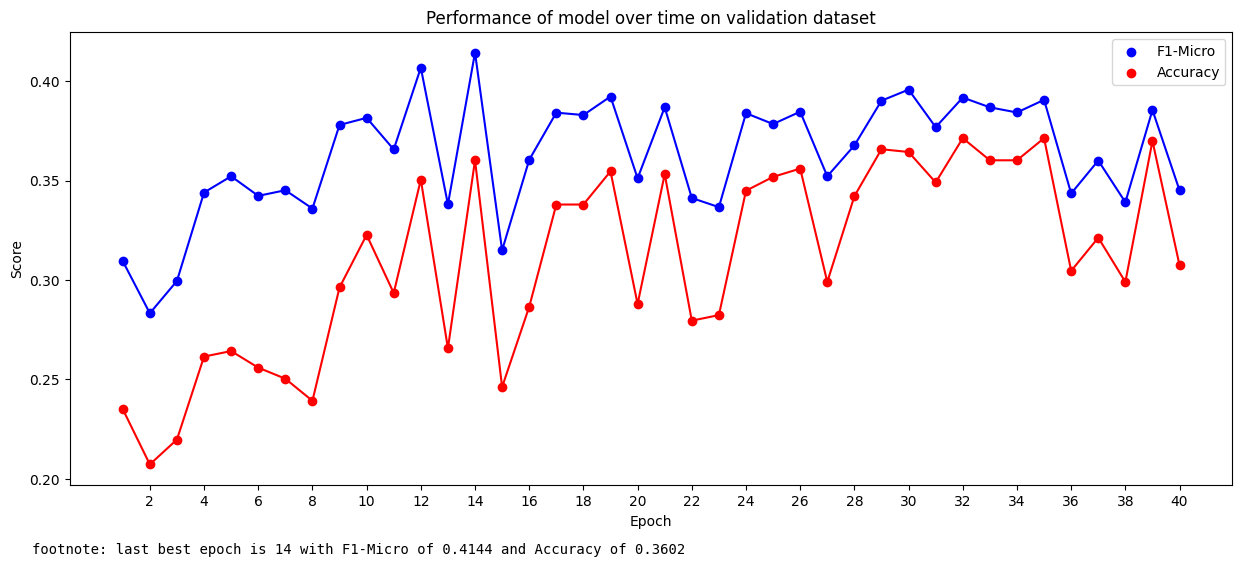

In [70]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/LSTM/performance.png"
plot_performance(performance, path)

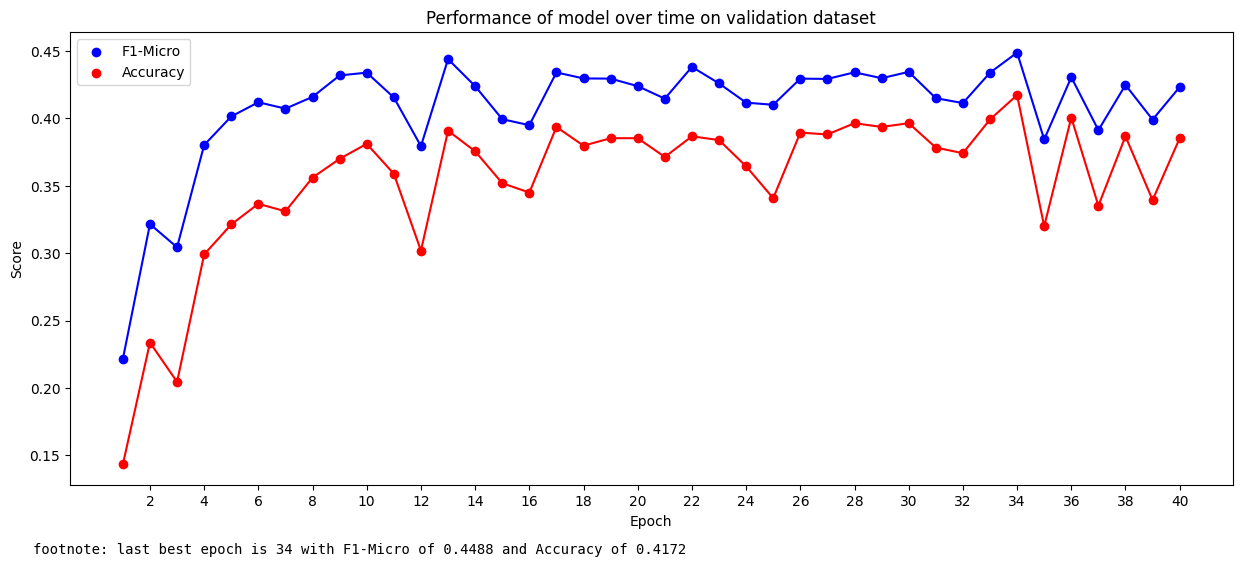

In [73]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/LSTM/performance.png"
plot_performance(performance, path)

##Evaluation

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.2899505766062603
Accuracy Score = 0.24444444444444444

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.0000    0.0000    0.0000        16
          Appeal_to_fear-prejudice     0.0000    0.0000    0.0000        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         7
           Black-and-White_Fallacy     0.0000    0.0000    0.0000        13
         Causal_Oversimplification     0.0000    0.0000    0.0000        23
                             Doubt     0.2264    0.2143    0.2202        56
         Exaggeration,Minimisation     0.2188    0.1296    0.1628        54
                       Flag-Waving     0.3333    0.0312    0.0571        32
                   Loaded_Language     0.4249    0.5429    0.4767       245
             Name_Calling,Labeling     0.2472    0.1774    0.2066       124
                        Repetition  

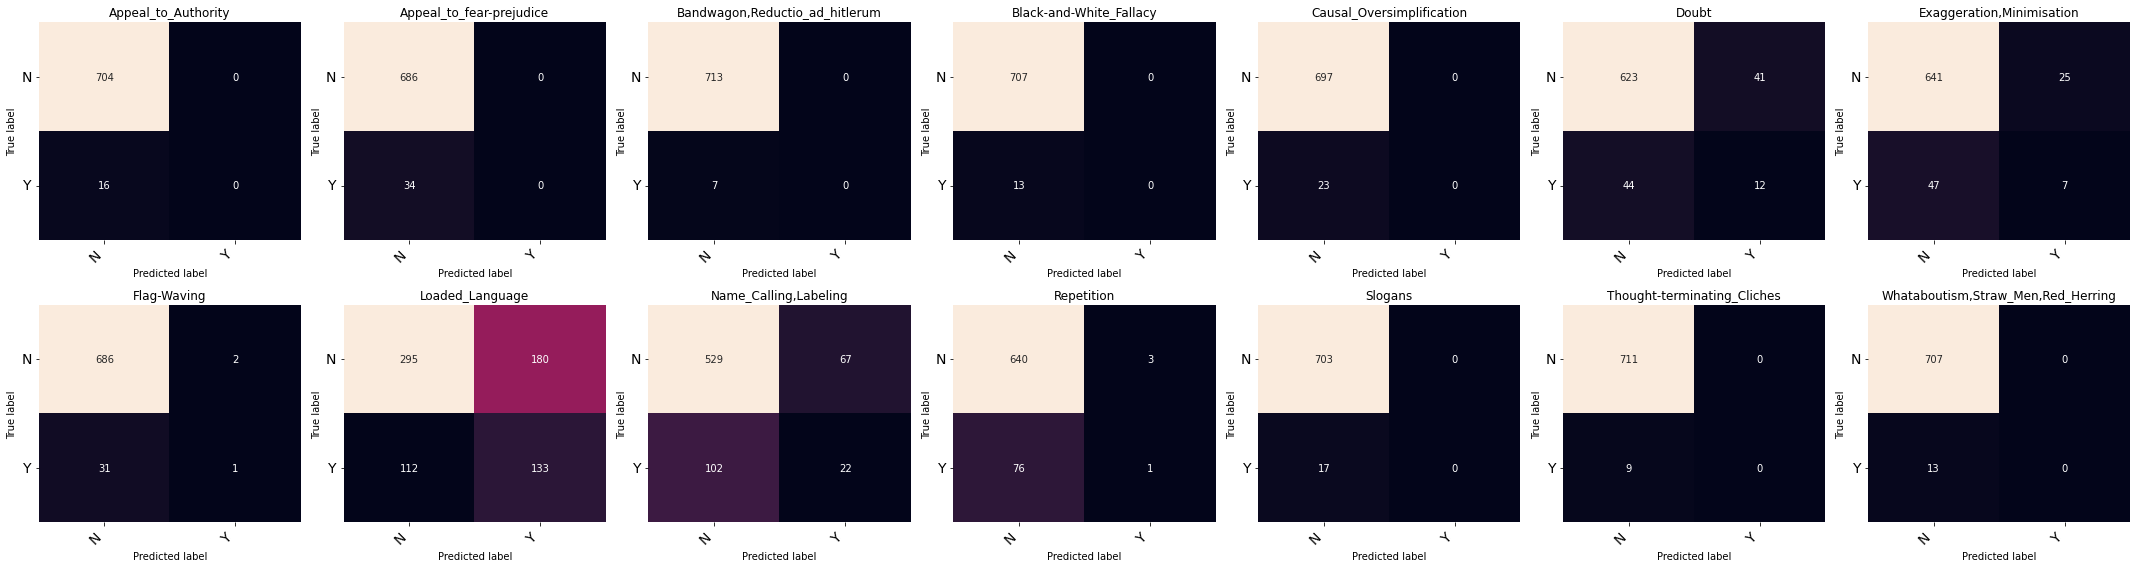

In [81]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/LSTM/Bilstm_model_aravec.json"
f = open(path,)
model_args = json.load(f)
f.close()

model = BiLSTM_model(max_features=model_args['max_features'],
                    embedding_dim=model_args['embedding_size'],
                    hidden_dim=model_args['lstm_hidden_dim'],
                    num_layers = model_args['num_lstm_layers'],
                    lstm_dropout = model_args['lstm_dropout'],
                    pretrained_embeddings=pretrained_embeddings)

model.load_state_dict(torch.load(model_args['model_save_path']))

Test(train, valid, test, model)

# AraVec debugging

In [14]:
# -*- coding: utf8 -*-
import gensim
import re

# load the model
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Aravec/wikipedia_cbow_100')

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

# python 3.X
word = clean_str(u'القاهرة')
# python 2.7
# word = clean_str('القاهرة'.decode('utf8', errors='ignore'))

# find and print the most similar terms to a word
most_similar = model.wv.most_similar( word )
for term, score in most_similar:
	print(term, score)
	
# get a word vector
word_vector = model.wv[ word ]

الاسكندريه 0.8658431768417358
دمشق 0.8266810178756714
بالقاهره 0.7823779582977295
بيروت 0.7714158296585083
بغداد 0.7700562477111816
حلوان 0.7399762868881226
استانبول 0.7359240651130676
اسطنبول 0.7213525772094727
حلب 0.718092143535614
بورسعيد 0.7143833637237549


In [35]:
word_vectors = model.wv
for i in range (0,10):
  print(f"{i}: '{word_vectors.index2word[i]}'")

0: ''
1: '.'
2: 'في'
3: 'من'
4: 'علي'
5: '('
6: ')'
7: 'غير_لائق'
8: 'الي'
9: 'ان'


In [36]:
word = 'علي'
word_vectors.vocab[word].index

4

In [ ]:
import gensim

def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

model_weights = gensim.models.Word2Vec.load('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Aravec/wikipedia_cbow_100').wv

In [ ]:
token = clean_str(u'مرحبا ايها الظلام يا صديقي القديم')

In [ ]:
model.wv.vectors

array([[-0.67446756,  1.664754  ,  1.2522125 , ..., -1.501293  ,
        -0.23380877,  0.9576053 ],
       [-0.36055776,  0.96951485,  0.70158213, ..., -0.63271683,
         0.56955826,  0.8918271 ],
       [ 0.53381014,  1.929988  ,  0.17052716, ..., -2.9228024 ,
         1.8024875 ,  1.4035356 ],
       ...,
       [-0.10735148, -0.1469917 ,  0.13361974, ...,  0.06530276,
         0.11617539, -0.07209087],
       [-0.05125982, -0.19183215,  0.12992346, ..., -0.0843755 ,
         0.03397764, -0.20429544],
       [ 0.10464962, -0.20680976,  0.03746011, ...,  0.0958457 ,
         0.08912268, -0.00895636]], dtype=float32)

In [ ]:
weights = model.wv

In [ ]:
weights

In [ ]:
vocab = []
counter = 0
for token in model.wv:
  if counter < 20:
    vocab.append(token)
  else:
    break

TypeError: ignored

#CNN

In [13]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import gensim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

##Trainer Code

In [14]:
def Train(train, valid, test, pretrained_embeddings=None):
  target_names = [
    'Appeal_to_Authority',
    'Appeal_to_fear-prejudice',
    'Bandwagon,Reductio_ad_hitlerum',
    'Black-and-White_Fallacy',
    'Causal_Oversimplification',
    'Doubt',
    'Exaggeration,Minimisation',
    'Flag-Waving',
    'Loaded_Language',
    'Name_Calling,Labeling',
    'Repetition',
    'Slogans',
    'Thought-terminating_Cliches',
    'Whataboutism,Straw_Men,Red_Herring']
  train_loader, valid_loader, _ = get_dataloaders(train,
                                                  valid,
                                                  test,
                                                  vocabulary=pretrained_embeddings.index2word
                                                  )

  device = torch.device(config['device'])

  model = CNN_model(pretrained_embeddings=pretrained_embeddings,
                      freeze_embedding=config['freeze_embedding'],
                      vocab_size=config['vocab_size'],
                      embedding_dim=config['embedding_dim'],
                      filter_sizes=config['filter_sizes'],
                      num_filters=config['num_filters'],
                      dropout=config['dropout'])
  model.to(device)

  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])
  loss_function = nn.BCEWithLogitsLoss()

  best_score = 0
  last_best_epoch = 0
  performance = []
  for epoch in range(config['epochs']):
    train_fn(train_loader, model, optimizer, device)
    outputs, targets = eval_fn(valid_loader, model, device)
    outputs = np.array(outputs) >= 0.5

    accuracy = metrics.accuracy_score(targets, outputs)
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Micro':f1_micro,
                         'Accuracy':accuracy,
                         }
    performance.append(epoch_performance)
    if f1_micro > best_score:
      print("Saving model...")
      report = metrics.classification_report(targets,outputs,target_names=target_names, zero_division=0, digits=4)
      torch.save(model.state_dict(), config['model_save_path'])
      best_score = f1_micro
      last_best_epoch = epoch+1
  print(report)

  with open(config['model_args_path'], 'w') as fp:
    json.dump(config, fp)
  return performance, last_best_epoch

##Model Archi

In [15]:
class CNN_model(nn.Module):
  def __init__(self,
               pretrained_embeddings=None,
               freeze_embedding=False,
               vocab_size=None,
               embedding_dim=300,
               filter_sizes = [3, 4, 5],
               num_filters=[100, 100, 100],
               dropout=0.5
               ):
    super(CNN_model, self).__init__()
    if pretrained_embeddings is not None:
      weights = torch.FloatTensor(pretrained_embeddings.vectors)
      self.vocab_size, self.embedding_dim = weights.shape
      self.embedding = nn.Embedding.from_pretrained(weights,
                                                    freeze=freeze_embedding)
    else:
      self.embedding_dim = embedding_dim
      self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                    embedding_dim=self.embedding_dim,
                                    padding_idx=0,
                                    max_norm=5.0)
    
    self.conv1d_list = nn.ModuleList(
        [
         nn.Conv1d(in_channels=self.embedding_dim,
         out_channels=num_filters[i],
         kernel_size=filter_sizes[i])
         for i in range(len(filter_sizes))
    ])
    self.fc = nn.Linear(np.sum(num_filters), config['num_classes'])
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, input_ids):
    x_embed = self.embedding(input_ids).float()

    # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
    # Output shape: (b, embedding_dim, max_len)
    x_reshaped = x_embed.permute(0, 2, 1)

    # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
    x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

    # Max pooling. Output shape: (b, num_filters[i], 1)
    x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
        for x_conv in x_conv_list]
    
    # Concatenate x_pool_list to feed the fully connected layer.
    # Output shape: (b, sum(num_filters))
    x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                      dim=1)
    
    # Compute logits. Output shape: (b, n_classes)
    logits = self.fc(self.dropout(x_fc))

    return logits

##Debugging

In [ ]:
train_loader, _, _ = get_dataloaders(train, valid, test)

device = torch.device(config['device'])

In [ ]:
class CNN_model(nn.Module):
  def __init__(self,
               pretrained_embedding=None,
               freeze_embedding=False,
               vocab_size=None,
               embedding_dim=300,
               filter_sizes = [3, 4, 5],
               num_filters=[100, 100, 100],
               dropout=0.5
               ):
    super(CNN_model, self).__init__()
    if pretrained_embedding is not None:
      self.vocab_size, self.embedding_dim = pretrained_embedding.shape
      self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                    freeze=freeze_embedding)
    else:
      self.embedding_dim = embedding_dim
      self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                    embedding_dim=self.embedding_dim,
                                    padding_idx=0,
                                    max_norm=5.0)
    
    self.conv1d_list = nn.ModuleList(
        [
         nn.Conv1d(in_channels=self.embedding_dim,
         out_channels=num_filters[i],
         kernel_size=filter_sizes[i])
         for i in range(len(filter_sizes))
    ])
    self.fc = nn.Linear(np.sum(num_filters), config['num_classes'])
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, input_ids):
    x_embed = self.embedding(input_ids).float()
    # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
    # Output shape: (b, embedding_dim, max_len)
    x_reshaped = x_embed.permute(0, 2, 1)

    # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
    x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

    # Max pooling. Output shape: (b, num_filters[i], 1)
    x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
        for x_conv in x_conv_list]
    
    # Concatenate x_pool_list to feed the fully connected layer.
    # Output shape: (b, sum(num_filters))
    x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                      dim=1)
    
    # Compute logits. Output shape: (b, n_classes)
    logits = self.fc(self.dropout(x_fc))

    return (x_embed, x_reshaped, x_conv_list, x_pool_list, x_fc, logits)

In [ ]:
model = CNN_model(pretrained_embedding=None,
                    freeze_embedding=config['freeze_embedding'],
                    vocab_size=config['vocab_size'],
                    embedding_dim=config['embedding_dim'],
                    filter_sizes=config['filter_sizes'],
                    num_filters=config['num_filters'],
                    dropout=config['dropout'])

model.to(device)

CNN_model(
  (embedding): Embedding(30000, 23, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(23, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(23, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(23, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=14, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
  x_embed, x_reshaped, x_conv_list, x_pool_list, x_fc, logits = model(inputs)
  break

  0%|          | 0/1918 [00:00<?, ?it/s]

In [ ]:
x_embed.shape

torch.Size([3, 50, 23])

In [ ]:
x_reshaped.shape

torch.Size([3, 23, 50])

In [ ]:
for something in x_conv_list:
  print(something.shape)

torch.Size([3, 100, 48])
torch.Size([3, 100, 47])
torch.Size([3, 100, 46])


In [ ]:
x_conv_list[0][0]

tensor([[0.0000, 0.0000, 0.3410,  ..., 0.5325, 0.0169, 0.9167],
        [0.1813, 0.0013, 0.5434,  ..., 0.2478, 0.9601, 0.0000],
        [0.0000, 0.0000, 0.4984,  ..., 0.0000, 1.2703, 0.0000],
        ...,
        [0.0000, 0.2159, 0.0178,  ..., 0.0000, 0.4078, 0.0000],
        [0.2712, 0.4330, 0.0548,  ..., 0.0000, 0.0000, 0.3200],
        [0.0000, 0.0000, 0.8397,  ..., 0.0000, 0.2394, 0.1887]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float) #input_1d.shape:  torch.Size([10])

input_2d = torch.tensor([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]], dtype = torch.float) #input_2d.shape:  torch.Size([2, 5])

input_2d_img = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
                             
                             [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
                             
                             [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]], dtype = torch.float) #torch.Size([3, 3, 10])

###1D Convolution

In [ ]:
cnn1d_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
input_1d = input_1d.unsqueeze(0).unsqueeze(0)
print("input_1d shape: ",input_1d.shape)
print("cnn1d_1: \n")
print(cnn1d_1(input_1d).shape, "\n")
print(cnn1d_1(input_1d))

input_1d shape:  torch.Size([1, 1, 10])
cnn1d_1: 

torch.Size([1, 1, 8]) 

tensor([[[1.0789, 1.3329, 1.5869, 1.8409, 2.0950, 2.3490, 2.6030, 2.8571]]],
       grad_fn=<SqueezeBackward1>)


In [ ]:
input_2d = input_2d.unsqueeze(0)
print(input_2d.shape)
cnn1d_5 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, stride=1)
print("cnn1d_5: \n")
print(cnn1d_5(input_2d).shape, "\n")
print(cnn1d_5(input_2d))

torch.Size([1, 2, 6])
cnn1d_5: 

torch.Size([1, 2, 4]) 

tensor([[[-3.4962, -3.5179, -3.5395, -3.5612],
         [-2.8852, -3.9203, -4.9554, -5.9905]]], grad_fn=<SqueezeBackward1>)


In [ ]:
def conv_single_step(a_slice_prev, W, b):
  """
  Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
  of the previous layer.

  Arguments:
  a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
  W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
  b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

  Returns:
  Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
  """

  ### START CODE HERE ### (≈ 2 lines of code)
  # Element-wise product between a_slice_prev and W. Do not add the bias yet.
  s = np.multiply(a_slice_prev, W)
  # Sum over all entries of the volume s.
  Z = np.sum(s)
  # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
  Z = Z + float(b)
  ### END CODE HERE ###

  return Z


[Coursera Assignments](https://github.com/amanchadha/coursera-deep-learning-specialization)

In [ ]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


##Config and Training

In [16]:
config = {
    'max_features': 120000, # how many unique words to use (i.e num rows in embedding vector)
    'maxlen': 200, # max number of words in a training sample
    'num_classes':14,

    'train_batch_size': 32, # how many train-samples to process per batch
    'valid_batch_size': 16, # how many valid-samples to process per batch

    'epochs': 15, # how many times to iterate over all samples
    'learning_rate': 5e-3,
    
    'freeze_embedding': False,
    'vocab_size':30000,
    'embedding_dim': 23,
    'filter_sizes':[3, 4, 5],
    'num_filters': [100, 100, 100],
    'dropout': 0.5,

    'device': 'cuda',
    'model_save_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/CNN/CNN_model.bin",
    'model_args_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/CNN/CNN_model.json",
}

In [55]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

Aravec = gensim.models.Word2Vec.load('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Aravec/SM/www_sg_300')
pretrained_embeddings = Aravec.wv

In [56]:
performance = {}
performance['MODEL_EPOCHS'] , performance['LAST_BEST_EPOCH'] = Train(train=train,
                                                                     valid=valid,
                                                                     test=test,
                                                                     pretrained_embeddings=pretrained_embeddings)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.18729096989966554
Accuracy Score = 0.1168289290681502
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.3330457290767903
Accuracy Score = 0.26842837273991654
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.20604703247480405
Accuracy Score = 0.12795549374130738


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.28571428571428575
Accuracy Score = 0.19193324061196107


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.3488372093023256
Accuracy Score = 0.2712100139082058
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.3569506726457399
Accuracy Score = 0.2767732962447844
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.37243947858473
Accuracy Score = 0.27816411682892905
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.33926897844423615
Accuracy Score = 0.2517385257301808


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.3931914893617021
Accuracy Score = 0.32127955493741306
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.413290113452188
Accuracy Score = 0.35465924895688455
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Micro Score = 0.3969722455845248
Accuracy Score = 0.3282336578581363


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Micro Score = 0.33242506811989103
Accuracy Score = 0.2545201668984701


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Micro Score = 0.38270616493194554
Accuracy Score = 0.33240611961057026


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Micro Score = 0.3914081145584725
Accuracy Score = 0.34214186369958277


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Micro Score = 0.3191126279863481
Accuracy Score = 0.26008344923504867


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 16--------------->
f1-Micro Score = 0.38095238095238093
Accuracy Score = 0.3337969401947149


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 17--------------->
f1-Micro Score = 0.39255236617532974
Accuracy Score = 0.3518776077885953


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 18--------------->
f1-Micro Score = 0.37431480031323416
Accuracy Score = 0.33240611961057026


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 19--------------->
f1-Micro Score = 0.36876006441223835
Accuracy Score = 0.3184979137691238


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 20--------------->
f1-Micro Score = 0.3844393592677346
Accuracy Score = 0.35048678720445064
                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.0000    0.0000    0.0000        16
          Appeal_to_fear-prejudice     0.2500    0.0294    0.0526        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         8
           Black-and-White_Fallacy     0.0000    0.0000    0.0000        13
         Causal_Oversimplification     0.0000    0.0000    0.0000        22
                             Doubt     0.3898    0.4107    0.4000        56
         Exaggeration,Minimisation     0.0000    0.0000    0.0000        53
                       Flag-Waving     0.5455    0.1935    0.2857        31
                   Loaded_Language     0.5307    0.6694    0.5921       245
             Name_Calling,Labeling     0.4118    0.2823    0.3349       124
                        Repetition     0.5532    

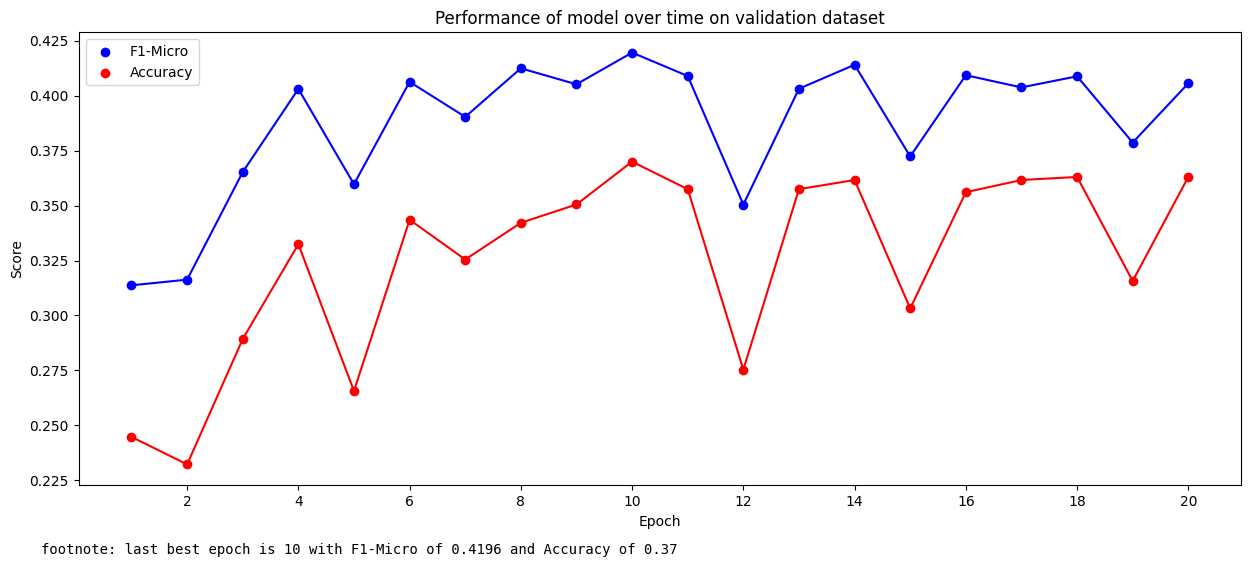

In [54]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/CNN/performance.png"
plot_performance(performance, path)

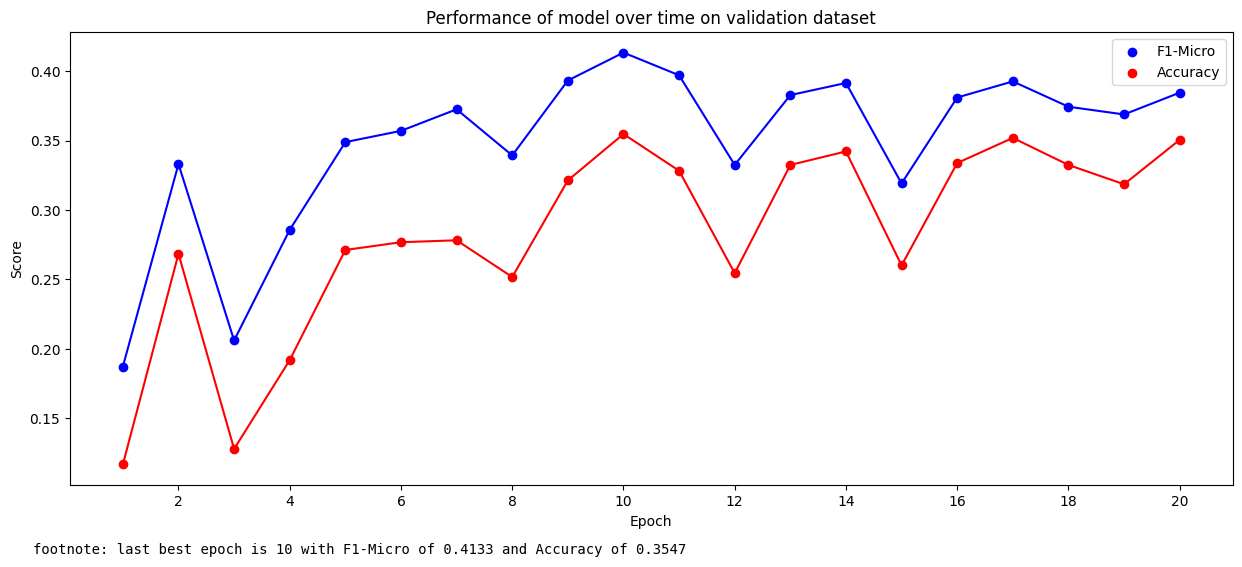

In [57]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/CNN/performance.png"
plot_performance(performance, path)

##Evaluation

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.44513137557959814
Accuracy Score = 0.4

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.5000    0.1250    0.2000        16
          Appeal_to_fear-prejudice     0.2692    0.2059    0.2333        34
    Bandwagon,Reductio_ad_hitlerum     0.3333    0.1429    0.2000         7
           Black-and-White_Fallacy     0.1667    0.0769    0.1053        13
         Causal_Oversimplification     0.5000    0.2609    0.3429        23
                             Doubt     0.4167    0.2679    0.3261        56
         Exaggeration,Minimisation     0.3393    0.3519    0.3455        54
                       Flag-Waving     0.5263    0.3125    0.3922        32
                   Loaded_Language     0.5962    0.5184    0.5546       245
             Name_Calling,Labeling     0.5376    0.4032    0.4608       124
                        Repetition     0.5227    0.

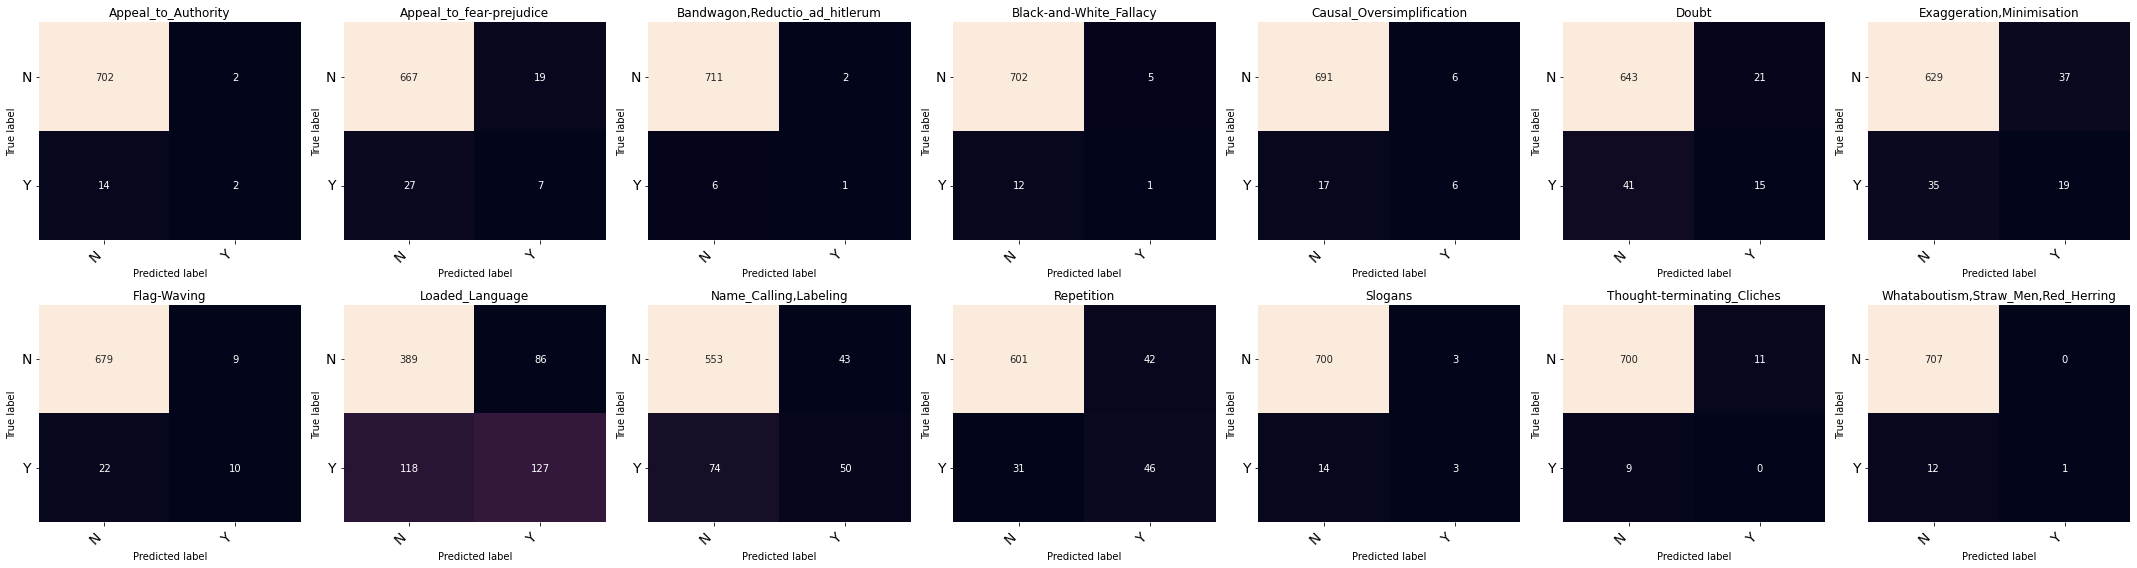

In [ ]:
path = "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/CNN_model.json"
f = open(path,)
model_args = json.load(f)
f.close()

model = CNN_model(pretrained_embeddings=pretrained_embeddings,
                    freeze_embedding=model_args['freeze_embedding'],
                    vocab_size=model_args['vocab_size'],
                    embedding_dim=model_args['embedding_dim'],
                    filter_sizes=model_args['filter_sizes'],
                    num_filters=model_args['num_filters'],
                    dropout=model_args['dropout'])

model.load_state_dict(torch.load(model_args['model_save_path']))

Test(train, valid, test, model)